In [1]:
import json
import pandas as pd
import altair as alt
from datetime import datetime, timedelta

In [2]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [3]:
df = pd.read_csv("./_data/sales.csv")

In [4]:
df.date = pd.to_datetime(df.date)

In [5]:
def percentage_change(old_value, new_value, multiply=True, fail_silently=True):
    """
    Accepts two integers, an old and a new number,
    and then measures the percent change between them.
    The change between the two numbers is determined
    and then divided into the original figure.
    By default, it is then multiplied by 100, and
    returning as a float.
    If you don't want the number multiplied by 100,
    set the 'multiply' kwarg to False.
    If you divide into zero -- an illegal operation -- a null value
    is returned by default. If you prefer for an error to be raised,
    set the kwarg 'fail_silently' to False.
    h3. Example usage
        >> import calculate
        >> calculate.percentage_change(2, 10)
        400.0
    h3. Documentation
        * "percentage_change":http://en.wikipedia.org/wiki/Percentage_change
    """
    change = new_value - old_value
    try:
        percentage_change = (change / float(old_value))
        if multiply:
            percentage_change = percentage_change * 100
        return percentage_change
    except ZeroDivisionError:
        # If there's a zero involved return null if set to fail silent
        if fail_silently:
            return None
        # but otherwise shout it all out
        else:
            raise ZeroDivisionError("Sorry. You can't divide into zero.")

## Promenade West

In [6]:
pwest = df[df.building_name == 'Promenade West']
pwest.to_csv("./_data/pwest_sales.csv", index=False)

In [7]:
def year_over_year_comparison(df):
    this_year = df[df.year == datetime.now().year]
    last_year = df[df.year == datetime.now().year - 1]
    stats = {
        'this_year': {
            'count': len(this_year),
            'median_price': this_year.price.median(),
            'median_price_per_sqft': this_year.price_per_square_foot.median(),
        },
        'last_year': {
            'count': len(last_year),
            'median_price': last_year.price.median(),
            'median_price_per_sqft': last_year.price_per_square_foot.median(),
        },
        'all_time': {
            'median_sqft': df.square_feet.median()
        }
    }
    stats.update({
        'change': {
            'price': percentage_change(stats['last_year']['median_price'], stats['this_year']['median_price']), 
            'median_price_per_sqft': percentage_change(stats['last_year']['median_price_per_sqft'], stats['this_year']['median_price_per_sqft']), 
        }
    })
    return stats

In [8]:
json.dump(year_over_year_comparison(pwest), open("./_data/pwest.json", "w"), indent=4)

### Most recent sales

In [9]:
pwest.sort_values("date", ascending=False)[[
    'building_name',
    'date',
    'unit',
    'price',
    'square_feet',
    'price_per_square_foot'
]].head(5)

,building_name,date,unit,price,square_feet,price_per_square_foot
1963,Promenade West,2018-07-03,308,620000.0,1323.0,468.631897
1964,Promenade West,2018-06-12,527,600000.0,1323.0,453.514739
1965,Promenade West,2018-04-11,706,598000.0,1348.0,443.620178
1966,Promenade West,2018-02-01,409,590000.0,1323.0,445.956160
1967,Promenade West,2018-01-24,315,615000.0,1509.0,407.554672


### The pace of sales

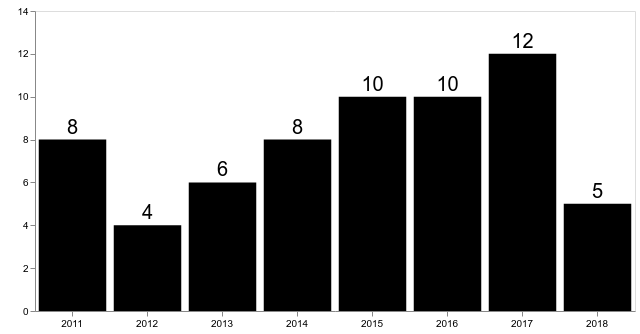

In [10]:
bars = alt.Chart(pwest).mark_bar(color="black").encode(
    x=alt.X("date:O", timeUnit="year", axis=alt.Axis(labelAngle=0, title="")),
    y=alt.Y("count()", scale=alt.Scale(domain=(0, 14)), axis=alt.Axis(title="", grid=False))
).properties(width=600)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-12,
    size=20
).encode(
    text='count()'
)

chart = bars + text

chart.configure_view(
    strokeOpacity=0
).save('assets/sales-by-year.svg')

chart

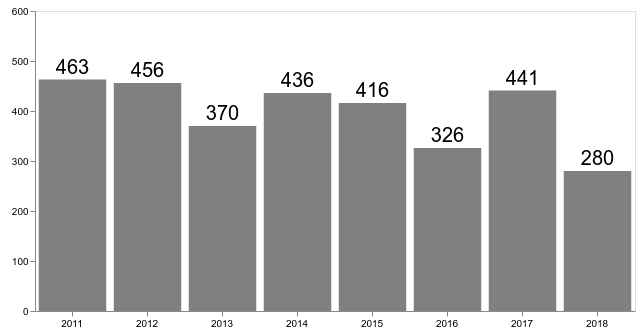

In [11]:
bars = alt.Chart(df).mark_bar(color="gray").encode(
    x=alt.X("date:O", timeUnit="year", axis=alt.Axis(labelAngle=0, title="")),
    y=alt.Y("count()", scale=alt.Scale(domain=(0, 600)), axis=alt.Axis(title="", grid=False))
).properties(width=600)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-12,
    size=20
).encode(
    text='count()'
)

chart = bars + text

chart.configure_view(
    strokeOpacity=0
).save('assets/dtla-sales-by-year.svg')

chart

### Prices by date

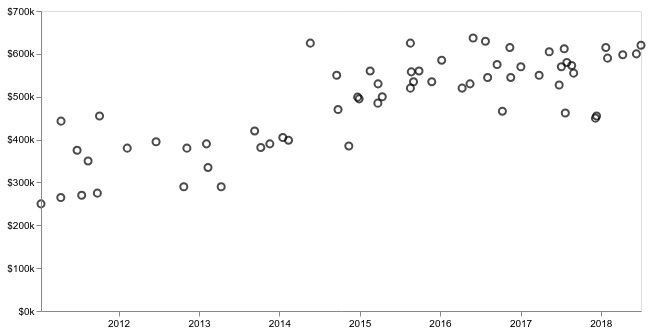

In [12]:
chart = alt.Chart(pwest).mark_point(size=50, color="black").encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(title="", format="%Y", tickCount=7, grid=False),
    ),
    y=alt.Y(
        "price:Q",
        axis=alt.Axis(title="", format="$s", grid=False),
        scale=alt.Scale(domain=[0, 700000])
    ),
    tooltip=["unit", "price", "square_feet", "price_per_square_foot"]
).properties(width=600)

chart.configure_view(
    strokeOpacity=0
).save('assets/price-by-date.svg')

chart

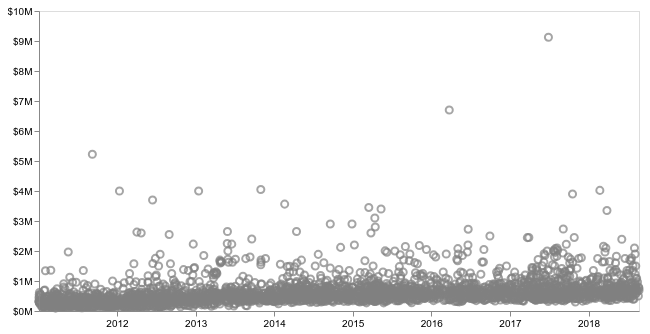

In [13]:
chart = alt.Chart(df).mark_point(size=50, color="gray").encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(title="", format="%Y", tickCount=7, grid=False),
    ),
    y=alt.Y(
        "price:Q",
        axis=alt.Axis(title="", format="$s", grid=False),
        scale=alt.Scale(domain=[0, 10000000])
    ),
    tooltip=["unit", "price", "square_feet", "price_per_square_foot"]
).properties(width=600)

chart.configure_view(
    strokeOpacity=0
).save('assets/dtla-price-by-date.svg')

chart

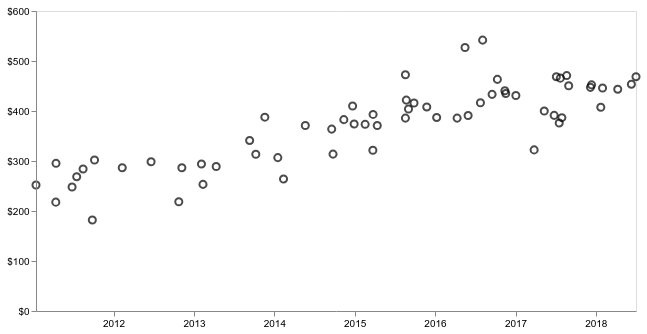

In [14]:
chart = alt.Chart(pwest).mark_point(size=50, color="black").encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(title="", format="%Y", tickCount=7, grid=False),
    ),
    y=alt.Y(
        "price_per_square_foot:Q",
        axis=alt.Axis(title="", format="$s", grid=False),
        scale=alt.Scale(domain=[0, 600])
    ),
    tooltip=["unit", "price", "square_feet", "price_per_square_foot"]
).properties(width=600)

chart.configure_view(
    strokeOpacity=0
).save('assets/price-per-sqft-by-date.svg')

chart

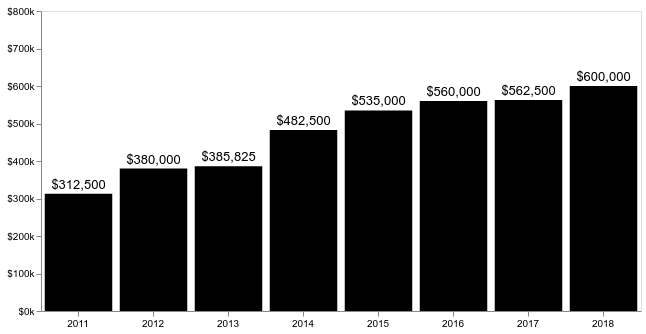

In [15]:
bars = alt.Chart(pwest).mark_bar(color="black").encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
        scale=alt.Scale(domain=[0, 750000]),
    ),
).properties(width=600)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-9,
    size=13
).encode(
    text=alt.Text('median(price):Q', format="$,.0f")
)

chart = bars + text

chart.configure_view(
    strokeOpacity=0
).save('assets/price-by-year.svg')

chart

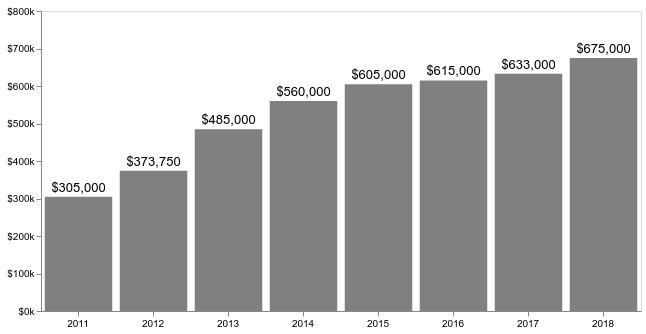

In [16]:
bars = alt.Chart(df).mark_bar(color="gray").encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
        scale=alt.Scale(domain=[0, 750000]),
    ),
).properties(width=600)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-9,
    size=13
).encode(
    text=alt.Text('median(price):Q', format="$,.0f")
)

chart = bars + text

chart.configure_view(
    strokeOpacity=0
).save('assets/dtla-price-by-year.svg')

chart

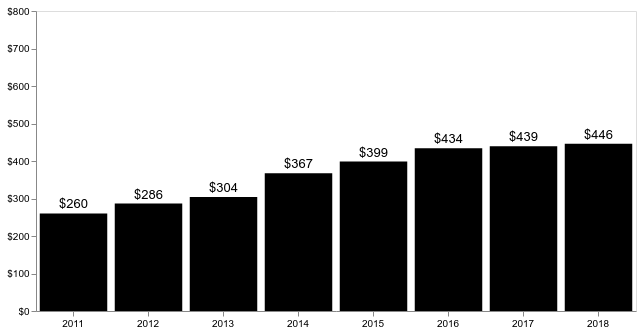

In [17]:
bars = alt.Chart(pwest).mark_bar(color="black").encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price_per_square_foot):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
        scale=alt.Scale(domain=[0, 750]),
    ),
).properties(width=600)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-9,
    size=13
).encode(
    text=alt.Text('median(price_per_square_foot):Q', format="$,.0f")
)

chart = bars + text

chart.configure_view(
    strokeOpacity=0
).save('assets/price-per-sqft-by-year.svg')

chart

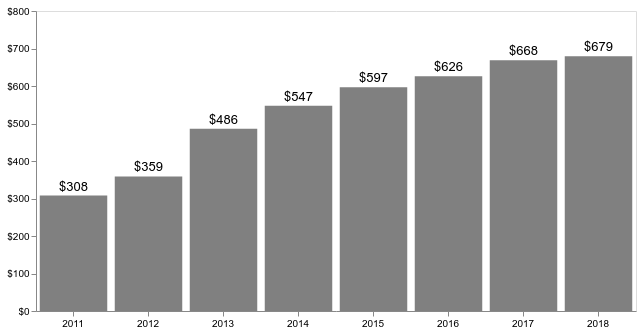

In [18]:
bars = alt.Chart(df).mark_bar(color="gray").encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price_per_square_foot):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
        scale=alt.Scale(domain=[0, 750]),
    ),
).properties(width=600)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-9,
    size=13
).encode(
    text=alt.Text('median(price_per_square_foot):Q', format="$,.0f")
)

chart = bars + text

chart.configure_view(
    strokeOpacity=0
).save('assets/dtla-price-per-sqft-by-year.svg')

chart

## Bunker Hill

In [19]:
bunker_hill = df[df.region == 'Bunker Hill']

In [20]:
json.dump(year_over_year_comparison(bunker_hill), open("./_data/bunkerhill.json", "w"), indent=4)

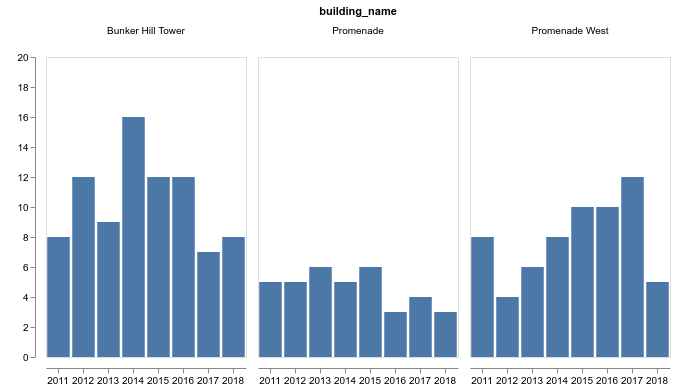

In [21]:
chart = alt.Chart(bunker_hill).mark_bar().encode(
    x=alt.X("date:O", timeUnit="year", axis=alt.Axis(labelAngle=0, title="")),
    y=alt.Y("count()", scale=alt.Scale(domain=(0, 20)), axis=alt.Axis(title="", grid=False)),
    column="building_name:N"
).properties(width=200)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/sales-by-year.svg')

chart

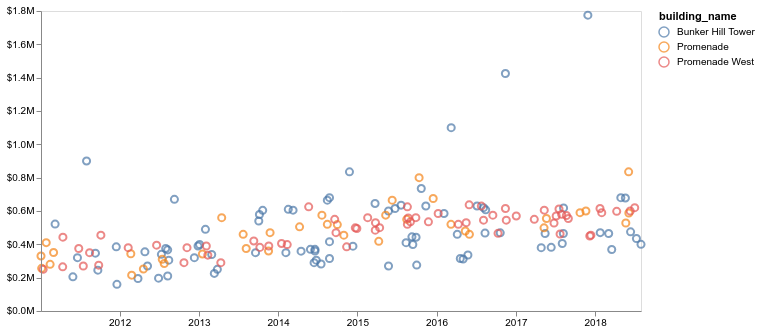

In [22]:
chart = alt.Chart(bunker_hill).mark_point(size=50).encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(title="", format="%Y", tickCount=7, grid=False),
    ),
    y=alt.Y(
        "price:Q",
        axis=alt.Axis(title="", format="$s", grid=False),
    ),
    color="building_name",
    tooltip=["building_name", "unit", "price", "square_feet", "price_per_square_foot"]
).properties(width=600)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-by-date.svg')

chart

In [46]:
bunker_hill.head()

,bathrooms,bedrooms,building_name,building_number,date,price,region,square_feet,unit,url,price_per_square_foot,year
588,1.0,0.0,Bunker Hill Tower,14,2018-08-01,400000.0,Bunker Hill,481.0,1409,https://www.dlxco.com/the-promenade-west-lofts...,831.600832,2018
589,1.0,0.0,Bunker Hill Tower,14,2018-07-11,435000.0,Bunker Hill,481.0,1304,https://www.dlxco.com/the-promenade-west-lofts...,904.365904,2018
590,1.0,1.0,Bunker Hill Tower,14,2018-06-14,475000.0,Bunker Hill,762.0,1702,https://www.dlxco.com/the-promenade-west-lofts...,623.359580,2018
591,2.0,2.0,Bunker Hill Tower,14,2018-05-21,678000.0,Bunker Hill,1234.0,1610,https://www.dlxco.com/the-promenade-west-lofts...,549.432739,2018
592,2.0,2.0,Bunker Hill Tower,14,2018-04-30,680000.0,Bunker Hill,1234.0,1203,https://www.dlxco.com/the-promenade-west-lofts...,551.053485,2018


In [83]:
pd.merge(
    bunker_hill.groupby(["building_name", 'year']).price.median().reset_index(),
    bunker_hill.groupby(["building_name", 'year']).price_per_square_foot.median().reset_index()
).pivot(index="year")

ValueError: cannot label index with a null key

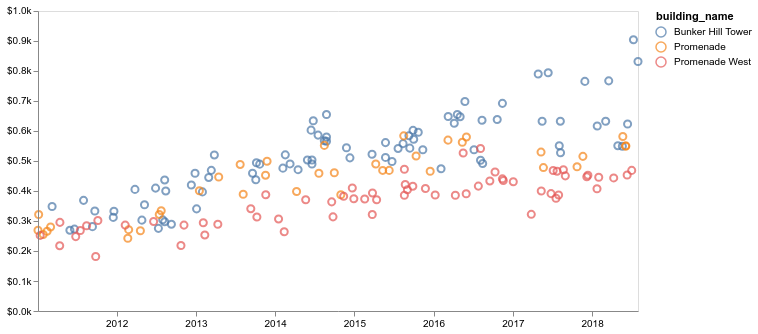

In [23]:
chart = alt.Chart(bunker_hill).mark_point(size=50).encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(title="", format="%Y", tickCount=7, grid=False),
    ),
    y=alt.Y(
        "price_per_square_foot:Q",
        axis=alt.Axis(title="", format="$s", grid=False)
    ),
    color="building_name:N",
    tooltip=["building_name", "unit", "price", "square_feet", "price_per_square_foot"]
).properties(width=600)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-per-sqft-by-date.svg')

chart

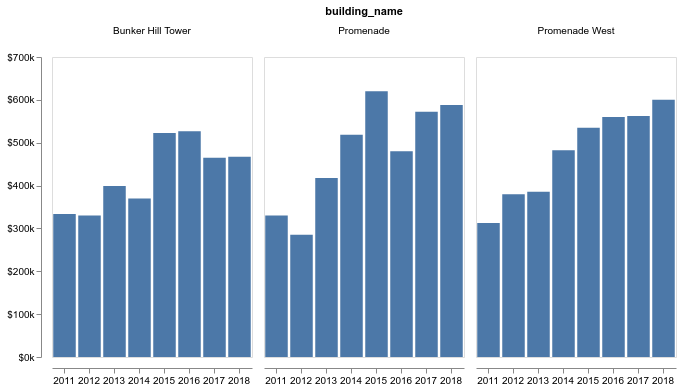

In [24]:
chart = alt.Chart(bunker_hill).mark_bar().encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
        scale=alt.Scale(domain=[0, 700000]),
    ),
    column="building_name:N"
).properties(width=200)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-by-year.svg')

chart

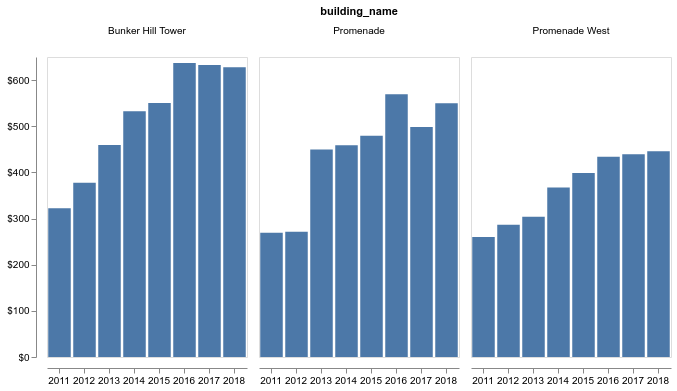

In [25]:
chart = alt.Chart(bunker_hill).mark_bar().encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price_per_square_foot):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
    ),
    column="building_name:N"
).properties(width=200)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-by-year.svg')

chart

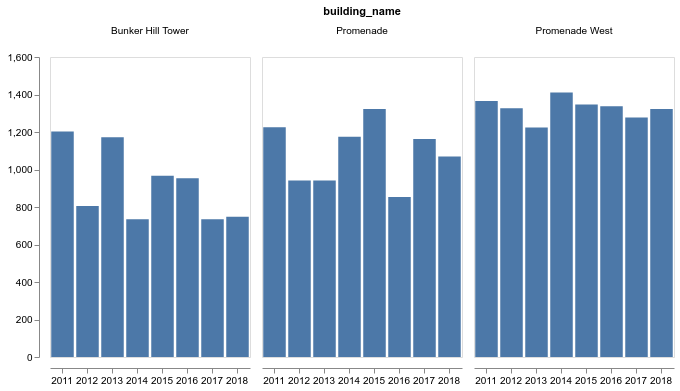

In [26]:
chart = alt.Chart(bunker_hill).mark_bar().encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(square_feet):Q",
        axis=alt.Axis(title="", grid=False),
    ),
    column="building_name:N"
).properties(width=200)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-by-year.svg')

chart

## Region

In [27]:
json.dump(year_over_year_comparison(df), open("./_data/dtla.json", "w"), indent=4)

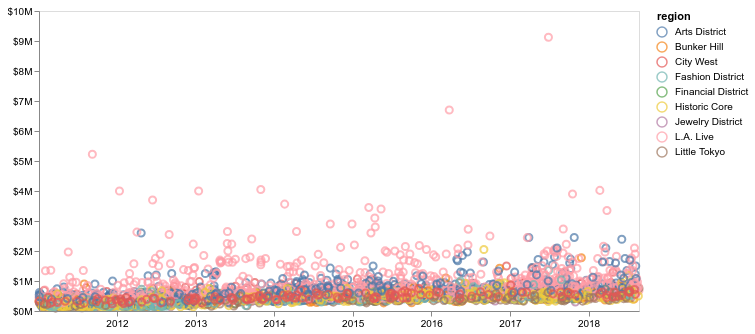

In [28]:
chart = alt.Chart(df).mark_point(size=50).encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(title="", format="%Y", tickCount=7, grid=False),
    ),
    y=alt.Y(
        "price:Q",
        axis=alt.Axis(title="", format="$s", grid=False),
    ),
    color="region",
    tooltip=["region", "building_name", "unit", "price", "square_feet", "price_per_square_foot"]
).properties(width=600)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-by-date.svg')

chart

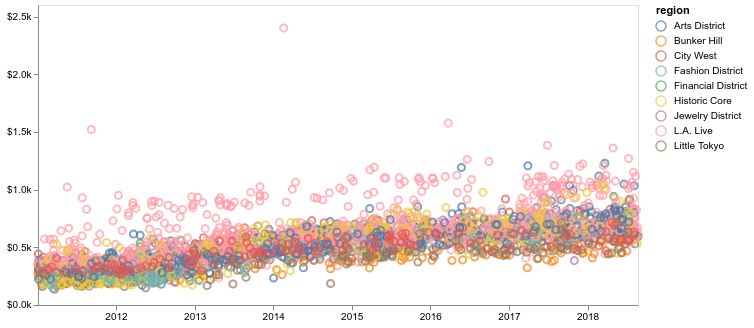

In [29]:
chart = alt.Chart(df).mark_point(size=50).encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(title="", format="%Y", tickCount=7, grid=False),
    ),
    y=alt.Y(
        "price_per_square_foot:Q",
        axis=alt.Axis(title="", format="$s", grid=False),
    ),
    color="region",
    tooltip=["region", "building_name", "unit", "price", "square_feet", "price_per_square_foot"]
).properties(width=600)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-by-date.svg')

chart

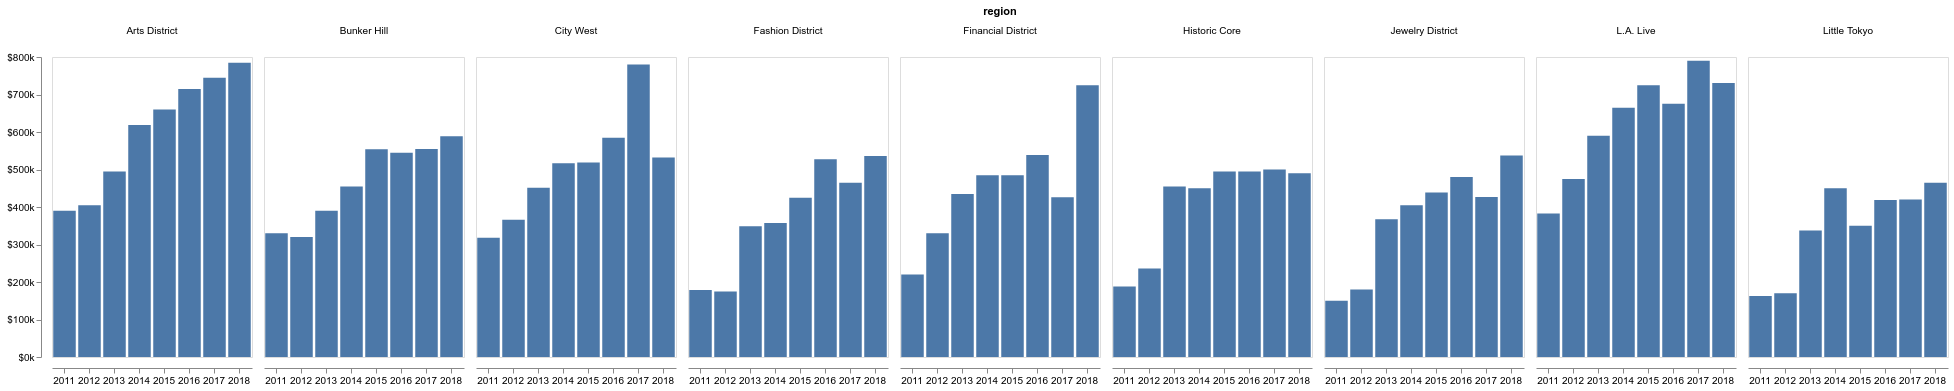

In [30]:
chart = alt.Chart(df).mark_bar().encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
    ),
    column="region:N"
).properties(width=200)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-by-year.svg')

chart

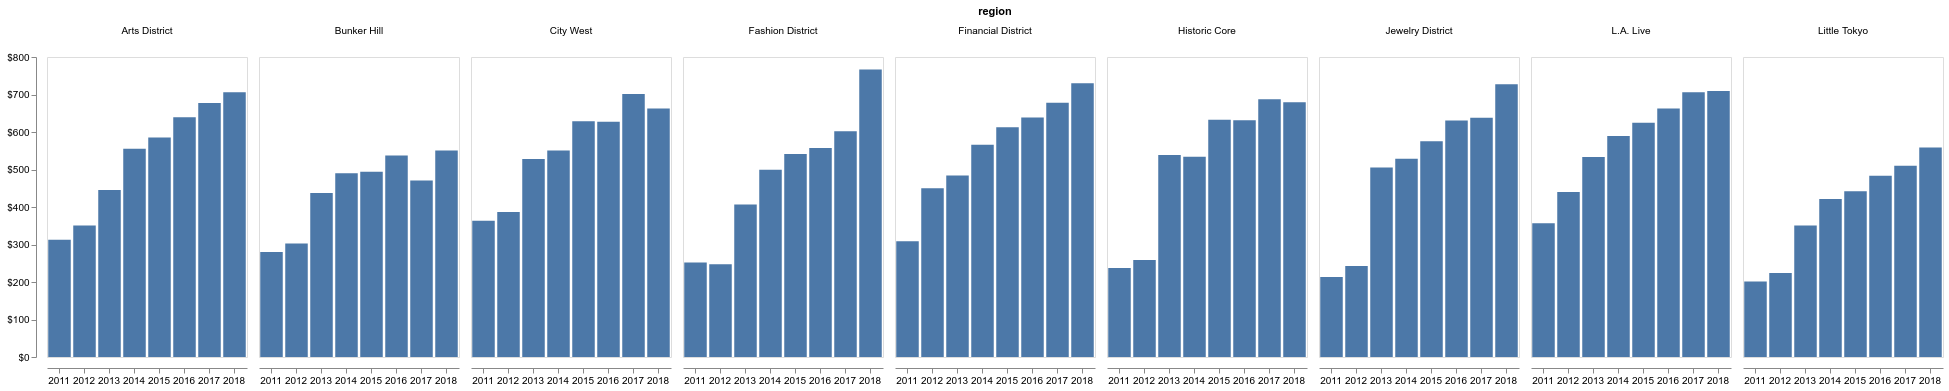

In [31]:
chart = alt.Chart(df).mark_bar().encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price_per_square_foot):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
    ),
    column="region:N"
).properties(width=200)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-by-year.svg')

chart

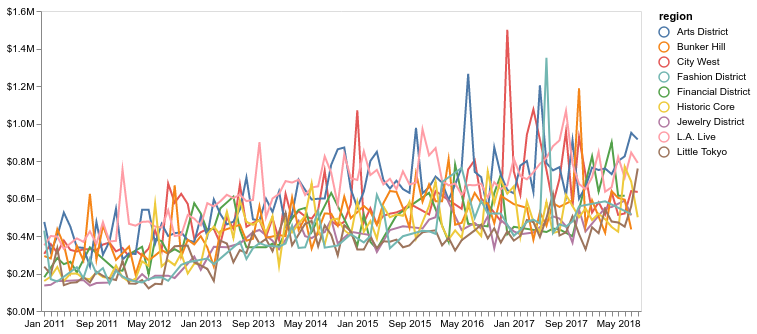

In [32]:
chart = alt.Chart(df).mark_line().encode(
    x=alt.X(
        "date:O",
        timeUnit="yearmonth",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
    ),
    color="region:N"
).properties(width=600)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-by-year.svg')

chart

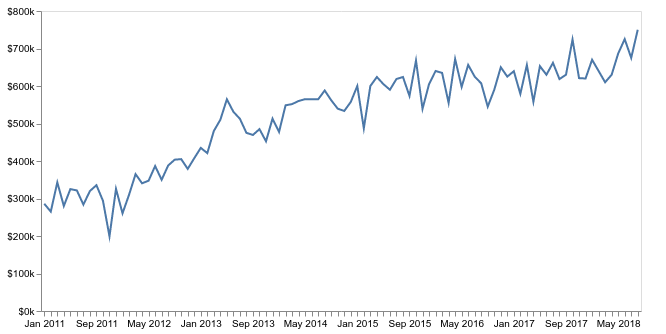

In [33]:
chart = alt.Chart(df).mark_line().encode(
    x=alt.X(
        "date:O",
        timeUnit="yearmonth",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
    ),
).properties(width=600)

# chart.configure_view(
#     strokeOpacity=0
# ).save('assets/price-by-year.svg')

chart

## Rankings

In [35]:
building_ranking = df.groupby(["building_name", "region"]).agg({
    "unit": "count",
    "price": "median",
    "price_per_square_foot": "median",
    "square_feet": "median",
})

In [36]:
building_ranking.sort_values("price_per_square_foot", ascending=False)

,,price,square_feet,unit,price_per_square_foot
building_name,region,,,,
Metropolis Tower II,L.A. Live,900000.0,709.0,1,1269.393512
Metropolis Tower I,L.A. Live,973000.0,977.0,18,1098.527822
Ritz Carlton,L.A. Live,1760000.0,1845.0,100,977.558339
Ten50,L.A. Live,995000.0,1084.0,53,926.384840
The Rowan,Historic Core,509900.0,827.0,97,673.611111
Luma Lofts,L.A. Live,619500.0,990.0,152,650.268817
Concerto Lofts,L.A. Live,635000.0,997.5,22,636.906918
Douglas,Historic Core,465000.0,950.0,31,629.729730
Biscuit Company Lofts,Arts District,725000.0,1112.0,63,626.425856


In [37]:
region_ranking = df.groupby(["region"]).agg({
    "unit": "count",
    "price": "median",
    "price_per_square_foot": "median",
    "square_feet": "median",
})

In [38]:
region_ranking.sort_values("price_per_square_foot", ascending=False)

,price,square_feet,unit,price_per_square_foot
region,,,,
L.A. Live,640000.0,1160.0,1136,610.001620
Financial District,412500.0,745.0,102,545.571391
City West,500000.0,940.0,256,544.776119
Historic Core,420000.0,820.0,358,540.841400
Arts District,585000.0,1171.0,677,524.126456
Jewelry District,389000.0,740.0,91,521.739130
Bunker Hill,465000.0,1172.0,184,452.273794
Fashion District,355000.0,790.0,147,447.761194
Little Tokyo,360000.0,853.0,237,428.169014


## Last 12 months

In [39]:
one_year_ago = datetime.now() - timedelta(days=365)

In [40]:
last_year = df[df.date > one_year_ago]

In [41]:
last_year.groupby(["building_name", "region"]).agg({
    "unit": "count",
    "price": "median",
    "price_per_square_foot": "median",
    "square_feet": "median",
}).sort_values("price_per_square_foot", ascending=False)

,,price,square_feet,unit,price_per_square_foot
building_name,region,,,,
Metropolis Tower II,L.A. Live,900000.0,709.0,1,1269.393512
Metropolis Tower I,L.A. Live,803000.0,783.0,9,1115.660184
Ritz Carlton,L.A. Live,1750000.0,1686.0,15,1063.186813
Ten50,L.A. Live,1112510.0,1147.5,20,985.294118
Biscuit Company Lofts,Arts District,855000.0,1082.0,12,923.667389
The Rowan,Historic Core,620000.0,720.0,11,901.960784
Gallery Lofts,Arts District,743000.0,901.0,4,819.232250
Barker Block Warehouse,Arts District,827500.0,1081.0,6,794.419064
Santee Village: Cornell,Fashion District,499000.0,650.0,3,767.692308


In [42]:
df.groupby(["region"]).agg({
    "unit": "count",
    "price": "median",
    "price_per_square_foot": "median",
    "square_feet": "median",
}).sort_values("price_per_square_foot", ascending=False)

,price,square_feet,unit,price_per_square_foot
region,,,,
L.A. Live,640000.0,1160.0,1136,610.001620
Financial District,412500.0,745.0,102,545.571391
City West,500000.0,940.0,256,544.776119
Historic Core,420000.0,820.0,358,540.841400
Arts District,585000.0,1171.0,677,524.126456
Jewelry District,389000.0,740.0,91,521.739130
Bunker Hill,465000.0,1172.0,184,452.273794
Fashion District,355000.0,790.0,147,447.761194
Little Tokyo,360000.0,853.0,237,428.169014


## Largest units

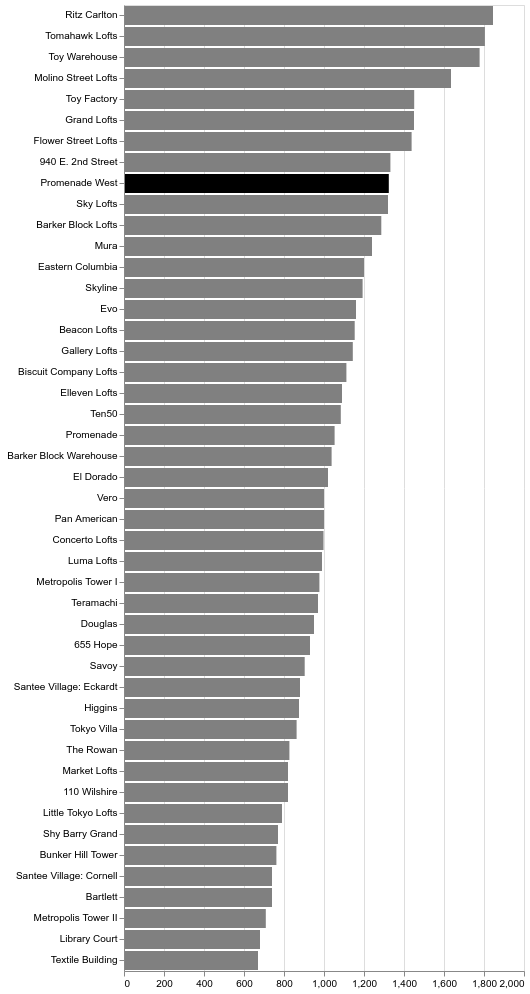

In [43]:
chart = alt.Chart(df).mark_bar().encode(
    x=alt.X(
        "median(square_feet):Q",
        axis=alt.Axis(title="")
    ),
    y=alt.Y(
        "building_name:N",
        axis=alt.Axis(title=""),
        sort=alt.SortField(field="square_feet", op="median", order="descending")
    ),
    color=alt.condition(
        alt.datum.building_name == 'Promenade West',
        alt.value("black"),
        alt.value("gray")
    )
)

chart.configure_view(
    strokeOpacity=0
).save('assets/size-by-building.svg')

chart